In [1]:
from sporco import util
import sporco.metric as sm
from sporco import plot
from sporco.admm import ccmod
from sporco.linalg import fftconv, fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tensorly import kruskal_to_tensor, kron
from tensorly.tenalg import khatri_rao

Using numpy backend.


In [2]:
# Dimensions of the K-CDL model

N1 = 5
N2 = 6
N3 = 7
N = np.product((N1, N2, N3))

W1 = 2
W2 = 3
W3 = 4

K = 3
R = 2

In [3]:
# Components in Temporal domain

Y = np.random.normal(size=(N1, N2, N3))

D = np.random.normal(size=(K, W1, W2, W3))
D_pad = np.zeros((K, N1, N2, N3))
D_pad[:, :W1, :W2, :W3] = D

Z1 = np.random.normal(size=(K, N1, R))
Z2 = np.random.normal(size=(K, N2, R))
Z3 = np.random.normal(size=(K, N3, R))
Z = np.zeros((K, N1, N2, N3))
for k in range(K):
    Z[k] = kruskal_to_tensor((Z1[k], Z2[k], Z3[k]))

In [4]:
# Components in Frequency domain

Yc = fftn(Y, axes=[0, 1, 2])

Dc = fftn(D, axes=[1, 2, 3])
Dc_pad = np.zeros((K, N1, N2, N3), dtype = np.complex)
Dc_pad[:, :W1, :W2, :W3] = Dc.copy()
Dc_pad = fftn(D_pad, axes=[1, 2, 3])

Z1c = fftn(Z1, axes=[1])
Z2c = fftn(Z2, axes=[1])
Z3c = fftn(Z3, axes=[1])
Zc = np.zeros((K, N1, N2, N3), dtype = np.complex)
for k in range(K):
    Zc[k] = kruskal_to_tensor((Z1c[k], Z2c[k], Z3c[k]))

In [5]:
# Plancherel theorem on Y (print need to be 0)
print(np.linalg.norm(Y)**2 - np.linalg.norm(Yc)**2/N)

2.842170943040401e-14


In [6]:
# Check lemma 1 (print need to be 0)
Zc_check = fftn(Z, axes=[1, 2, 3])

print(np.linalg.norm(Zc - Zc_check))

1.0790282092503556e-13


In [7]:
# Check theorem 1 (print need to be 0)

Ypred = np.sum(np.array([fftconv(D_pad[k], Z[k], axes=[0, 1, 2]) for k in range(K)]), axis=0)
Ycpred = np.sum(np.array([np.multiply(Dc_pad[k], Zc[k]) for k in range(K)]), axis=0)

print(0.5 * np.linalg.norm(Y - Ypred)**2 - 0.5 * np.linalg.norm(Yc - Ycpred)**2/N)

5.4569682106375694e-12


In [8]:
# Specific ordering of the indexes during the vectorization
def unfold(tensor, mode, order='F'):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order=order)
def ravel(X, order='F'):
    return np.ravel(X, order=order)

In [9]:
# Check corollary
yc_0 = ravel(unfold(Yc, mode=0))

dc_0_diag = np.array([np.diag(ravel(unfold(Dc_pad[k], mode=0))) for k in range(K)])
Gammac = np.hstack(dc_0_diag)

z1_0 = np.reshape(Z1, (K, N1 * R), order='F').ravel()
z1c_0 = np.reshape(Z1c, (K, N1 * R), order='F').ravel()

Bc = np.array([khatri_rao((Z3c[k], Z2c[k])) for k in range(K)])
    
Ac = np.zeros((K*N2*N3, K*R), dtype=np.complex)
for k in range(K):
    Ac[k*N2*N3 : (k+1)*N2*N3, k*R:(k+1)*R] = Bc[k]
    
I_1 = np.identity(N1)

M = Gammac.dot(kron(Ac, I_1))

In [10]:
# Check corollary (print need to be 0)
print(np.linalg.norm(Y - Ypred)**2 - np.linalg.norm(yc_0 - M.dot(z1c_0))**2/N)

1.0913936421275139e-11


In [11]:
# Check for kronecker outside (print need to be 0)

Bc_check = np.array([kron(khatri_rao((Z3c[k], Z2c[k])), I_1) for k in range(K)])
Ac_check = np.zeros((K*N, K*R*N1), dtype=np.complex)
for k in range(K):
    Ac_check[k*N : (k+1)*N, k*R*N1:(k+1)*R*N1] = Bc_check[k]
    
print(np.linalg.norm(kron(Ac, I_1) - Ac_check))

0.0


In [12]:
# Just for visualization
y_0 = ravel(unfold(Y, mode=0)) # unused

d_0_diag = np.array([np.diag(ravel(unfold(D[k], mode=0))) for k in range(K)])
Gamma = np.hstack(d_0_diag)

B = np.array([khatri_rao((Z3[k], Z2[k])) for k in range(K)])

A = np.zeros((K*N2*N3, K*R))
for k in range(K):
    A[k*N2*N3 : (k+1)*N2*N3, k*R:(k+1)*R] = B[k]

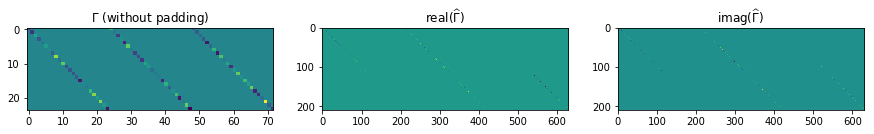

In [13]:
# Visualization of matrix Gamma
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(Gamma)
plt.title('$\Gamma$ (without padding)')
plt.subplot(132)
plt.title('real($\widehat{\Gamma}$)')
plt.imshow(np.real(Gammac))
plt.subplot(133)
plt.title('imag($\widehat{\Gamma}$)')
plt.imshow(np.imag(Gammac))

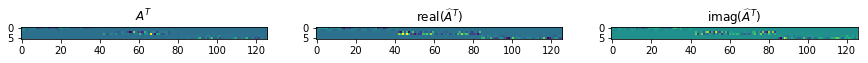

In [14]:
# Visualization of matrix A
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(A.T)
plt.title('$A^T$')
plt.subplot(132)
plt.title('real($\widehat{A}^T$)')
plt.imshow(np.real(Ac.T))
plt.subplot(133)
plt.title('imag($\widehat{A}^T$)')
plt.imshow(np.imag(Ac.T))

In [15]:
# Check proposition (print need to be 0)
Gram = M.conj().T.dot(M)

Gram_check = np.zeros((Gram.shape), dtype=np.complex)
for k in range(K):
    for l in range(K):
        dck_conj = dc_0_diag[k].conj().T
        dcl = dc_0_diag[l]

        Ack_conj = kron(khatri_rao((Z3c[k], Z2c[k])), I_1).conj().T
        Acl = kron(khatri_rao((Z3c[l], Z2c[l])), I_1)

        Block_kl = Ack_conj.dot(dck_conj).dot(dcl).dot(Acl)
        
        Gram_check[k*N1*R : (k+1)*N1*R, l*N1*R: (l+1)*N1*R] = Block_kl

print(np.linalg.norm(Gram - Gram_check))

5.261055715623732e-11


In [16]:
# Check the decomposition into smaller kronecker (print need to be 0)
k = 0
dc_0_diag_k_check = np.zeros((dc_0_diag[k].shape), dtype=np.complex)
for i in range(N2*N3):
    ei = np.zeros(N2*N3)
    ei[i] = 1
    
    delta_ki = dc_0_diag[k][i*N1:(i+1)*N1, i*N1:(i+1)*N1]
    
    dc_0_diag_k_check += kron(np.diag(ei), delta_ki)
    
print(np.linalg.norm(dc_0_diag[k] - dc_0_diag_k_check))

0.0


In [17]:
# Check the final decomposition of the Gram matrix (print need to be 0)

k = 0
l = 1
Ack_conj = kron(khatri_rao((Z3c[k], Z2c[k])), I_1).conj().T
Acl = kron(khatri_rao((Z3c[l], Z2c[l])), I_1)
dck_conj = dc_0_diag[k].conj().T
dcl = dc_0_diag[l]
Block_kl = Ack_conj.dot(dck_conj).dot(dcl).dot(Acl)

Block_kl_check = np.zeros((Block_kl.shape), dtype=np.complex)
Bck_conj = khatri_rao((Z3c[k], Z2c[k])).conj()
Bcl = khatri_rao((Z3c[l], Z2c[l]))

for i in range(N2*N3):
    
    delta_ki_conj = dc_0_diag[k][i*N1:(i+1)*N1, i*N1:(i+1)*N1].conj()
    delta_li = dc_0_diag[l][i*N1:(i+1)*N1, i*N1:(i+1)*N1]
    
    Block_kl_check += kron( np.outer(Bck_conj[i, :], Bcl[i, :]), delta_ki_conj*delta_li )
    
print(np.linalg.norm(Block_kl - Block_kl_check))

8.133042369113223e-12


Text(0.5, 1.0, '|imag(Gram)|>0')

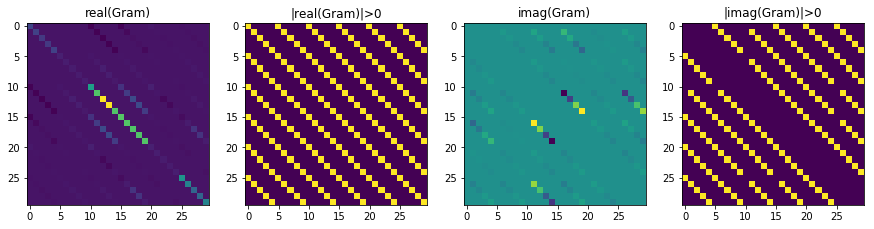

In [18]:
# Visualization of the particular structure of the Gram matrix
plt.figure(figsize=(15, 5))
plt.subplot(141)
plt.imshow(np.real(Gram))
plt.title('real(Gram)')
plt.subplot(142)
plt.imshow(abs((Gram))>0)
plt.title('|real(Gram)|>0')
plt.subplot(143)
plt.imshow(np.imag(Gram))
plt.title('imag(Gram)')
plt.subplot(144)
plt.imshow(abs(np.imag(Gram))>0)
plt.title('|imag(Gram)|>0')